     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00

Ingrese cantidad de operarios:

2

Ingrese cantidad de inyectoras:

2
   tiles_production  Tiles_Red  Tiles_Black
0                12          4            8
1                12          4            8
2                12          4            8


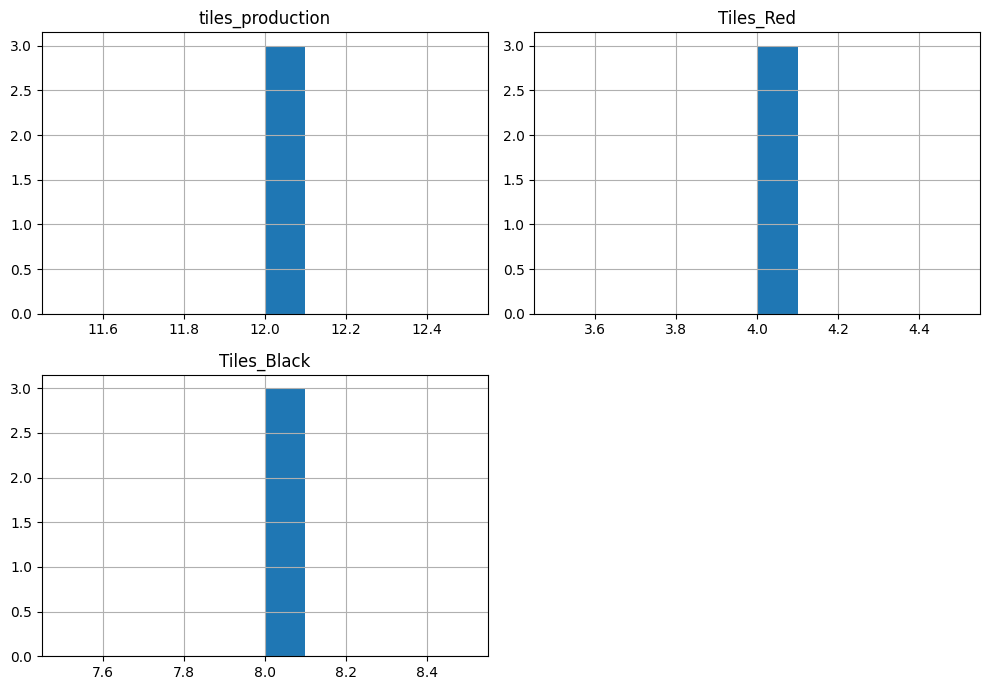

Archivo Excel generado exitosamente en: datos.xlsx
   tiles_production  Tiles_Red  Tiles_Black  Inyectoras  Operarios
0                12          4            8           2          2
1                12          4            8           2          2
2                12          4            8           2          2


In [1]:
!pip install salabim --upgrade
import salabim as sim
import pandas as pd
import matplotlib.pyplot as plt

print("\nIngrese cantidad de operarios:\n")
Operarios= int(input())
print("\nIngrese cantidad de inyectoras:\n")
Inyectoras= int(input())
Iter_num = 3
seg_per_day = 28800
Time_MasterbatchxPallet = 1600  # Segundos que tardo en masterbatch para producir un pallet
Pallet_tiles_per_seg = 2000  # Segundos para producir un pallet de tejas

class Counter:
    tiles_production = 0
    Tiles_Red = 0
    Tiles_BlacK = 0

def run_simulation():
    modelo = sim.Environment(trace=False)
    modelo.number_Pellet = 1203.93

    operator = sim.Resource('Operator', capacity=Operarios)
    masterbatch = sim.Resource('Masterbatch', capacity=Inyectoras)
    injector = sim.Resource('Injector', capacity=1)

    class MasterBatch(sim.Component):
        def process(self):
            if modelo.number_Pellet > 100.32:
                self.request(operator)
                self.request(masterbatch)
                self.hold(sim.Uniform(Time_MasterbatchxPallet, Time_MasterbatchxPallet * 1.1125).sample())
                self.release(masterbatch)
                self.release(operator)
                modelo.number_Pellet -= 100.32  # Decremento en 100.32 KG los pellets

    class Injector(sim.Component):
        def process(self):
            if modelo.number_Pellet > 100.32:
                self.request(operator)
                self.request(injector)
                self.hold(sim.Uniform(Pallet_tiles_per_seg, Pallet_tiles_per_seg * 1.12).sample())
                self.release(operator)
                self.release(injector)
                Counter.tiles_production += 1  # Incremento contador de tejas
                if Counter.Tiles_Red == 0:
                    Counter.Tiles_Red += 1
                elif (Counter.Tiles_Red / (Counter.Tiles_Red + Counter.Tiles_BlacK)) > 0.3:
                    Counter.Tiles_BlacK += 1
                else:
                    Counter.Tiles_Red += 1

    class PalletsGenerator(sim.Component):
        def process(self):
            self.hold(1)
            masterbatch_instance = MasterBatch()
            self.hold(1)
            injector_instance = Injector()

    sim.ComponentGenerator(PalletsGenerator, iat=sim.Exponential(1), force_at=True, number=100)

    modelo.speed(128000*8)
    modelo.run(seg_per_day)

    return Counter.tiles_production, Counter.Tiles_Red, Counter.Tiles_BlacK

results = []
for _ in range(Iter_num):
    # Reset Counter values for each iteration
    Counter.tiles_production = 0
    Counter.Tiles_Red = 0
    Counter.Tiles_BlacK = 0
    results.append(run_simulation())

df = pd.DataFrame(results, columns=['tiles_production', 'Tiles_Red', 'Tiles_Black'])
print(df)

df.hist(bins=10, figsize=(10, 7))
plt.tight_layout()
plt.show()

nueva_columna_Inyectoras = pd.Series([Inyectoras, Inyectoras,Inyectoras], name='Inyectoras')
df = pd.concat([df, nueva_columna_Inyectoras], axis=1)

nueva_columna_Operarios = pd.Series([Operarios, Operarios,Operarios], name='Operarios')
df = pd.concat([df, nueva_columna_Operarios], axis=1)

ruta_archivo = 'datos.xlsx'
df.to_excel(ruta_archivo, index=False)

print("Archivo Excel generado exitosamente en:", ruta_archivo)
print(df)